In [5]:

# these were in the holodeck notebooks, idk what they do
###
# %reload_ext autoreload
# %autoreload 2

# imports
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

# append sys path for holodeck
import sys
sys.path.append('C:/Users/emiga/OneDrive/Cal/GWs/code/holodeck/')

# import holodeck
import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
# wait to uncomment this until I need them, to see what dif they make
###
# mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
# mpl.rc('lines', solid_capstyle='round')
# mpl.rc('mathtext', fontset='cm')
# mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
# plt.rcParams.update({'grid.alpha': 0.5})

# define log
# log = holo.log # is this meant to be logger.py? I can't find log
# log.setLevel(logging.INFO)

construct SAM with default parameters

In [6]:

# define a sam using the default parameters 
# (did not need to write them all out but did so 
#  so I can copy and paste to make clear variations)
sam_default = holo.sam.Semi_Analytic_Model(
    mtot = (1.0e4*MSOL,1.0e11*MSOL, 61), 
    mrat=(1e-3, 1.0, 81), 
    redz=(1e-3, 10.0, 101),
    shape=None,
    gsmf=holo.sam.GSMF_Schechter, 
    gpf=holo.sam.GPF_Power_Law, 
    gmt=holo.sam.GMT_Power_Law, 
    mmbulge=holo.relations.MMBulge_MM2013
)
## default parameters:
######
# mtot=(1.0e4*MSOL, 1.0e11*MSOL, 61), 
# mrat=(1e-3, 1.0, 81), 
# redz=(1e-3, 10.0, 101),
# shape=None,
# gsmf=GSMF_Schechter, 
# gpf=GPF_Power_Law, 
# gmt=GMT_Power_Law, 
# mmbulge=relations.MMBulge_MM2013
######\


## could also set using 
# gsmf = holo.sam.GSMF_Schechter()               # Galaxy Stellar-Mass Function (GSMF)
# gpf = holo.sam.GPF_Power_Law()                 # Galaxy Pair Fraction         (GPF)
# gmt = holo.sam.GMT_Power_Law()                 # Galaxy Merger Time           (GMT)
# mmbulge = holo.relations.MMBulge_Standard()    # M-MBulge Relation            (MMB)
# hard = holo.evolution.Hard_GW()

choose observed GW frequency bins by nyquist sampling

Next, semi-analytic-models.ipynb 
* fobs_edges = utils.nyquist_freqs_edges(...) chooses edges of frequency bins
* gwb = sam.gwb(fobs_edges,...) calculates GW frequencies for many different realizations, function of fobs_edges
* plots realizations
* sam = sam.Semi_Analytic_Model using different gsmf, gpf, gmt, and mmbulge (before was default)
* calculate distrib of GWB amplitudes, plot




Or sam_discretization 
* defines a function sample_at_fbin to sample by frequency bin (*not sure what this means*), plots
* sample (discretize) assuming GW-driven evolutions
  - sample_sam_with_hardening to get vals, weights, edges, dens, mass, plot (*error here*)
  - gravwaves._strains_from_samples(vals) gets the strains using vals found in sample_sam_with_hardening -> GW driven only strains, plots
  - get GW (gw_freqs, gwf, gwb) for the grav-driven hardening sample using sam._gws_from_samples, plots
* do similar but now with realistic hardening rate...? is this an alternative method to prev sampling or this same sample after some evolution?

Or sam_turnover.ipynb
* gwb = sam.gwb(fobs, ...) calculates GWs for many realizations
* plots

simplest option seems to be to calculate GWB (without first defining edges) like in sam_turnover

In [11]:
# using fobs = utils.nyquist_freqs_
fobs_default = utils.nyquist_freqs(15*YR, .1*YR)
# timing parameters: 
#   dur = duration of observations, default 15*YR
#   cad = cadence of observation, default .1*YR
#   (optional) trim: boundaries, i.e remove values outside range

gwb_from_fobs = sam_default.gwb(fobs_default, realize = False)
# default: 
#  fobs_gw_edges needs defining, 
#  hard=holo.evolution.Hard_GW, 
#  realize=False, if this were left False, would not discretize
#                 by sampling from Poisson distribution
print(gwb_from_fobs.shape)

(74,)


(74,)


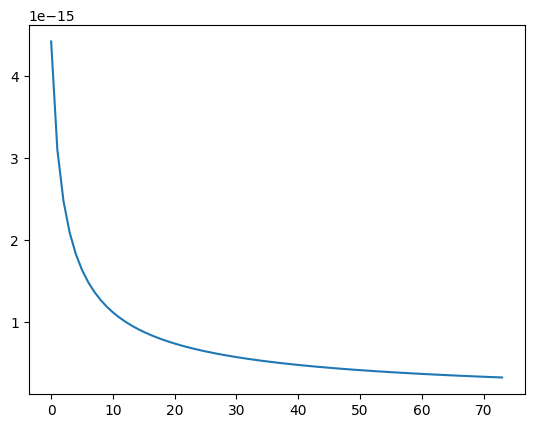

In [12]:
print(gwb_from_fobs.shape)
x_integers = np.linspace(0,len(gwb_from_fobs)-1, len(gwb_from_fobs))
plt.plot(x_integers, gwb_from_fobs)

In [15]:
# alternatively, using fobs_edges
fobs_edges_default = utils.nyquist_freqs_edges(15*YR, .1*YR)
# default parameters: 
# dur: float = 15.0*YR, 
# cad: float = 0.1*YR, 
# trim: Optional[Tuple[float, float]] = None

gwb_from_edges = sam_default.gwb(fobs_edges_default, realize = False)
print(gwb_from_edges.shape)

(75,)


(75,)


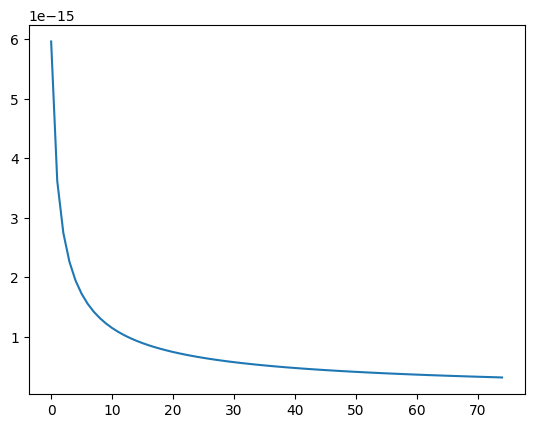

In [16]:
print(gwb_from_edges.shape)
x_integers = np.linspace(0,len(gwb_from_edges)-1, len(gwb_from_edges))
plt.plot(x_integers, gwb_from_edges)

Plot gwb_from_edges and gwb_from_fobs, both are not Poisson sampled

semi-analytic-model makes xx_sam shape = (75,)
sam_discretization makes xx.disc shape = (74,)
sam_turnover makes xx.turn shape = (74,)


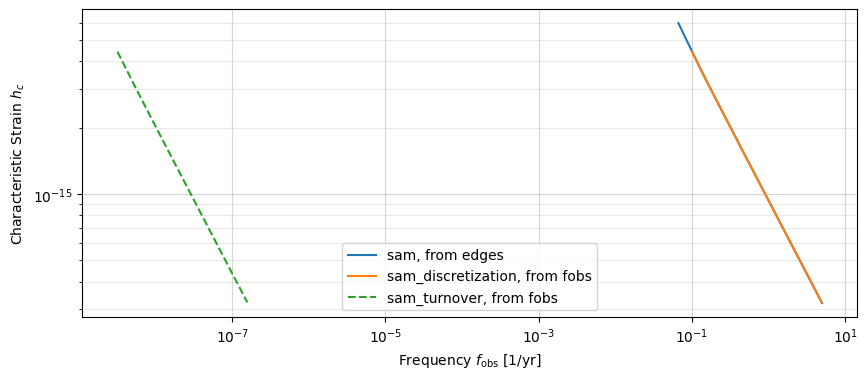

In [17]:
nsamp = 2
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]',
                     ylabel='Characteristic Strain $h_c$')
                     

# semi-analytic-model uses xx = fobs * YR
# this is the one that made gwb from edges
xx_sam = fobs_default * YR
print('semi-analytic-model makes xx_sam shape =',
        xx_sam.shape) # (75,)
# semi-analytic-model used  np.median(gwb, axis=-1) for y
# but we don't need median because only one realization
ax.plot(xx_sam, gwb_from_edges, label='sam, from edges')


# sam_discretiztion used xx = kale.utils.midpoints(fobs) * YR, 
# maybe this gets midpoints if the fobs array is edges
xx_disc = kale.utils.midpoints(fobs_default) * YR
print('sam_discretization makes xx.disc shape =', 
        xx_disc.shape) # (74,)
# instead of gwb = sam.gwb() they used
# gwf_freqs, gwf, gwb = holo.sam._gws_from_samples(vals, weights, fobs)
# but maybe gwb part is the same, not sure if weighting matters
# here we're plotting regular gwb, not their sampling version
ax.plot(xx_disc, gwb_from_fobs, label='sam_discretization, from fobs')

# sam_turnover used xx = (fobs[1:] + fobs[:-1]*0.5)
# seems like a way to get centers/edges since only fobs is defined
xx_turn = (fobs_default[1:] + fobs_default[:-1]) * 0.5
print('sam_turnover makes xx.turn shape =', 
        xx_turn.shape) # (74,)
ax.plot(xx_turn, gwb_from_fobs, label='sam_turnover, from fobs', 
linestyle = 'dashed')

# gwb description from sam.py : (F,[R,]) ndarray of scalar
#     Dimensionless, characteristic strain at each frequency.
#     If `realize` is an integer with value R, then R realizations of the GWB are returned,
#     such that `hc` has shape (F,R,).

# since mine has no sampling, shape is just 
# (74,) from fobs and (75,) from edges


ax.legend()

(75,)
